In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Embedding, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as pyplot
import pickle

In [3]:
df = pd.read_csv('conversation.csv')


In [5]:
df = df['question']
conv = df.to_list()

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(conv)
seq = tokenizer.texts_to_sequences(conv)


In [9]:
X = []
y = []
total_words_dropped = 0

for i in seq:
    if len(i) > 1:
        for index in range(1, len(i)):
            X.append(i[:index])
            y.append(i[index])
    else:
        total_words_dropped += 1

print("Total Single Words Dropped are:", total_words_dropped)


Total Single Words Dropped are: 33


In [86]:
X.shape

(19996, 18)

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
y = np.array(y)  # Keep y as integer-encoded labels
vocab_size = len(tokenizer.word_index) + 1

In [13]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
glove_path = 'glove.6B.300d.txt'

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in tokenizer.word_index:
            index = tokenizer.word_index[word]
            embedding_matrix[index] = coefs

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))  # Use pre-trained embeddings
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(vocab_size, activation='softmax'))

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [62]:
model.build(input_shape=(None, X.shape[1]))

In [64]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 18, 300)             │         717,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 18, 512)             │       1,140,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 18, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 18, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 18, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2392)                │       1,227,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,235,256 (23.79 MB)

 Trainable params: 6,235,256 (23.79 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history=model.fit(X, y, epochs=100,batch_size=64)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - accuracy: 0.0385 - loss: 6.5423
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.0839 - loss: 5.6492
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accuracy: 0.1184 - loss: 5.2075
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.1363 - loss: 4.8679
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.1605 - loss: 4.5866
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.1754 - loss: 4.3589
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.1897 - loss: 4.1550
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.2116 - loss: 3.9149
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.2186 - loss: 3.7808
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.2413 - loss: 3.5687
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.2602 - loss: 3.4361
Epoch 12

In [19]:
vocab_array = np.array(list(tokenizer.word_index.keys()))

In [68]:
def make_prediction(conv, n_words, top_n=3):
    conv = conv.lower()

    # Tokenize and pad the input text
    text = conv
    generated_text = text

    # Initialize list for storing top predictions
    top_words_probs = []

    for _ in range(n_words):
        text_tokenize = tokenizer.texts_to_sequences([text])
        text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_tokenize, maxlen=X.shape[1])

        # Predict probabilities for the next word
        prediction_probs = model.predict(text_padded, verbose=0)[0]

        # Get indices of the top_n predicted words
        top_indices = np.argsort(prediction_probs)[-top_n:]
        top_probs = np.sort(prediction_probs)[-top_n:]

        # Convert indices to words
        top_words = [list(tokenizer.word_index.keys())[index - 1] for index in top_indices]
        top_words_probs = list(zip(top_words, top_probs))

        # Determine the most probable word to add to the generated text
        predicted_word_index = np.argmax(prediction_probs)
        predicted_word = list(tokenizer.word_index.keys())[predicted_word_index - 1]

        # Append the predicted word to the generated text
        generated_text += " " + predicted_word

        # Update the text for the next iteration
        text += " " + predicted_word

    # Print the top_n probable next words
    print(f"\nTop {top_n} probable next words:")
    for i, (word, prob) in enumerate(top_words_probs, 1):
        print(f"{i}. Word: '{word}' - Probability: {prob:.4f}")

    # Print the generated sentence
    print("\nPredicted sentence:")
    print("--------------------")
    return generated_text


In [70]:
print(make_prediction("what", 1))


Top 3 probable next words:
1. Word: 'did' - Probability: 0.0907
2. Word: 'are' - Probability: 0.1067
3. Word: 'do' - Probability: 0.2222

Predicted sentence:
--------------------
what do


In [74]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
model.save('next_model.keras')

Text(0, 0.5, 'Loss')

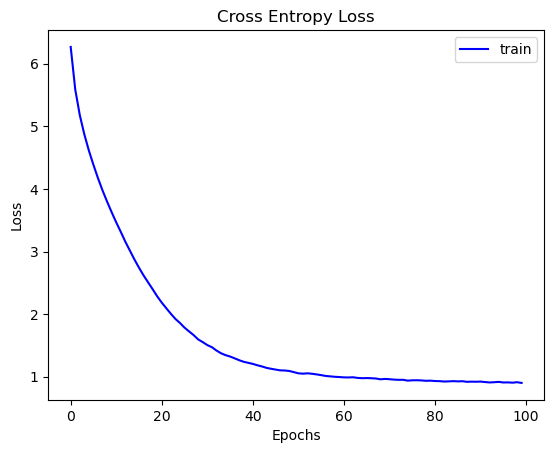

In [78]:
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

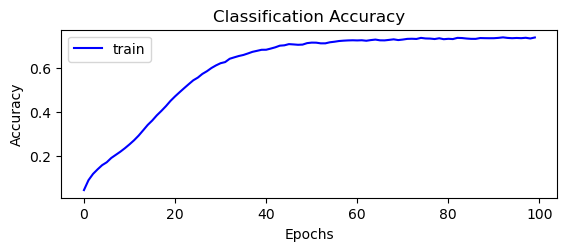

In [80]:
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')